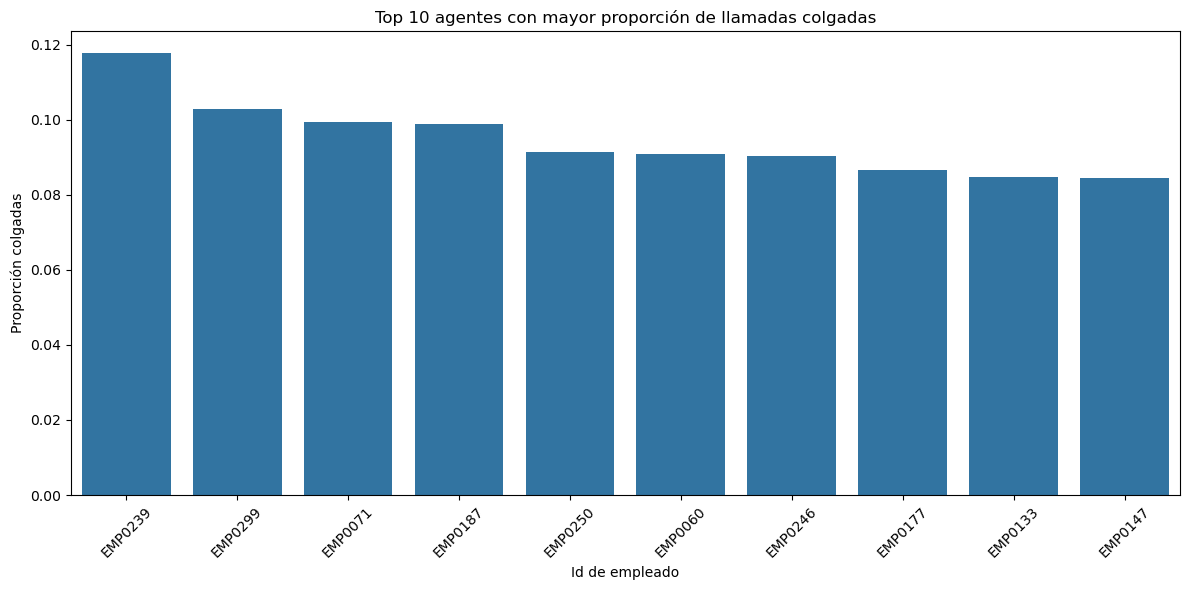

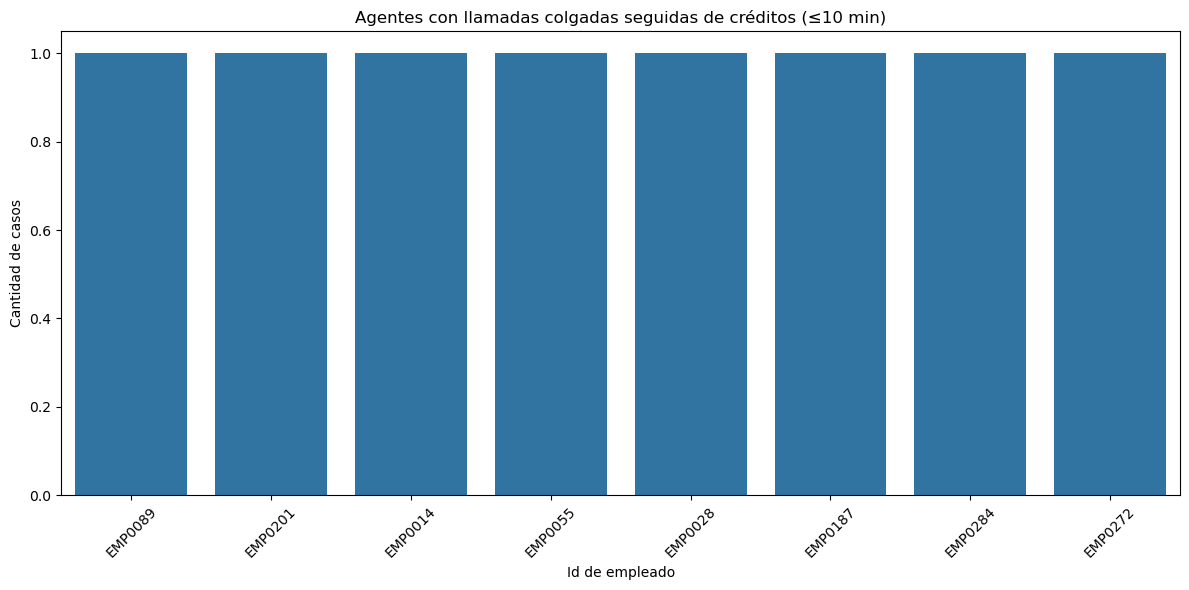

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los archivos desde tu ruta local
df_creditos = pd.read_excel(r"C:\Users\Creditos.xlsx")
df_llamadas_colgadas = pd.read_excel(r"C:\Users\Llamadas_Colgadas.xlsx")
df_interacciones = pd.read_excel(r"C:\Users\Data\Interacciones.xlsx")

# Asegurar formato de fechas
df_creditos['Fecha y hora de interacción'] = pd.to_datetime(df_creditos['Fecha y hora de interacción'])
df_llamadas_colgadas['Fecha y hora de interacción'] = pd.to_datetime(df_llamadas_colgadas['Fecha y hora de interacción'])
df_interacciones['Fecha y hora de interacción'] = pd.to_datetime(df_interacciones['Fecha y hora de interacción'])

# 1. Calcular proporción de llamadas colgadas por agente
total_interacciones = df_interacciones['Id de empleado'].value_counts().rename('Total_interacciones')
llamadas_colgadas = df_llamadas_colgadas['Id de empleado'].value_counts().rename('Llamadas_colgadas')

proporcion = pd.concat([total_interacciones, llamadas_colgadas], axis=1).fillna(0)
proporcion['Proporción_colgadas'] = proporcion['Llamadas_colgadas'] / proporcion['Total_interacciones']
proporcion = proporcion.reset_index().rename(columns={'index': 'Id de empleado'})

# 2. Filtrar agentes con proporción alta (> 20%)
agentes_alto_colgado = proporcion[proporcion['Proporción_colgadas'] > 0.2]

# 3. Detectar si hubo crédito posterior (≤ 10 minutos después de colgar)
df_llamadas_colgadas['Crédito_posterior'] = False
df_llamadas_colgadas['Minutos_a_credito'] = None

for idx, row in df_llamadas_colgadas.iterrows():
    agente = row['Id de empleado']
    fecha = row['Fecha y hora de interacción']
    
    ventana_credito = df_creditos[
        (df_creditos['Id de empleado'] == agente) &
        (df_creditos['Fecha y hora de interacción'] > fecha) &
        (df_creditos['Fecha y hora de interacción'] <= fecha + pd.Timedelta(minutes=10))
    ]
    
    if not ventana_credito.empty:
        df_llamadas_colgadas.loc[idx, 'Crédito_posterior'] = True
        df_llamadas_colgadas.loc[idx, 'Minutos_a_credito'] = (
            ventana_credito['Fecha y hora de interacción'].min() - fecha
        ).total_seconds() / 60

# 4. Resumen de casos sospechosos
sospechosos = df_llamadas_colgadas[df_llamadas_colgadas['Crédito_posterior'] == True]
top_sospechosos = sospechosos['Id de empleado'].value_counts().reset_index()
top_sospechosos.columns = ['Id de empleado', 'Colgadas_con_credito']

# ---------- GRÁFICO 1: Proporción de llamadas colgadas ----------
plt.figure(figsize=(12, 6))
top = proporcion.sort_values('Proporción_colgadas', ascending=False).head(10)
sns.barplot(data=top, x='Id de empleado', y='Proporción_colgadas')
plt.title('Top 10 agentes con mayor proporción de llamadas colgadas')
plt.xlabel('Id de empleado')
plt.ylabel('Proporción colgadas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- GRÁFICO 2: Casos sospechosos por agente ----------
plt.figure(figsize=(12, 6))
sns.barplot(data=top_sospechosos.head(10), x='Id de empleado', y='Colgadas_con_credito')
plt.title('Agentes con llamadas colgadas seguidas de créditos (≤10 min)')
plt.xlabel('Id de empleado')
plt.ylabel('Cantidad de casos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Exportar tabla sospechosa a Excel
sospechosos.to_excel(r"C:\Users\Colgadas_con_credito.xlsx", index=False)
